<a href="https://colab.research.google.com/github/MonikaSpakova/NN-/blob/main/K%C3%B3pia_z%C3%A1pisn%C3%ADka_Pneumonia_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# What is Pneumonia?

---


Pneumonia is an inflammatory condition of the lung affecting primarily the small air sacs known as alveoli.Symptoms typically include some combination of productive or dry cough, chest pain, fever and difficulty breathing. The severity of the condition is variable. Pneumonia is usually caused by infection with **viruses or bacteria** and less commonly by other microorganisms, certain medications or conditions such as autoimmune diseases.Risk factors include cystic fibrosis, chronic obstructive pulmonary disease (COPD), asthma, diabetes, heart failure, a history of smoking, a poor ability to cough such as following a stroke and a weak immune system. Diagnosis is often based on symptoms and physical examination. **Chest X-ray, blood tests, and culture of the sputum may help confirm the diagnosis.** The disease may be classified by where it was acquired, such as community- or hospital-acquired or healthcare-associated pneumonia.

---
The dataset is organized into 3 folders (train, test, val) and contains 
subfolders for each image category (Pneumonia/Normal). There are 5,863 X-Ray images (JPEG) and 2 categories (Pneumonia/Normal). 



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Library

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing

import matplotlib.pyplot as plt
import seaborn as sns
import keras
from tqdm import tqdm
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from keras.callbacks import ReduceLROnPlateau
import cv2
import os

import os
import cv2
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix
from keras.models import Model, load_model
from keras.layers import Dense, Input, Conv2D, MaxPool2D, Flatten

# Loading the Dataset

In [ ]:
labels = ['NORMAL']
img_size = 150
def get_training_data_normal(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

def get_training_data_pneumonia(data_dir):
    pneu_labels_number = []
    pneu_files = np.array(os.listdir(data_dir))
    pneu_labels = np.array([pneu_file.split('_')[1] for pneu_file in pneu_files])
    print(np.unique(pneu_labels, return_counts = True))

    for p in pneu_labels:
      if p == 'bacteria':
        pneu_labels_number.append(1)
      elif p == 'virus':
        pneu_labels_number.append(2)

    pneu_images = []
    i = 0
    for image in tqdm(pneu_files):
      try:
        image = cv2.imread(data_dir + image, cv2.IMREAD_GRAYSCALE)
        image = cv2.resize(image, (img_size, img_size))
        pneu_images.append([image, pneu_labels_number[i]])
      except Exception as e:
        print(e)
      i += 1
        
    return np.array(pneu_images)

In [ ]:
train_normal = get_training_data_normal('/content/drive/MyDrive/Colab Notebooks/Data/chest_xray/train')
train_pneumonia = get_training_data_pneumonia('/content/drive/MyDrive/Colab Notebooks/Data/chest_xray/train/PNEUMONIA/')
train = np.vstack((train_pneumonia, train_normal))

test_normal = get_training_data_normal('/content/drive/MyDrive/Colab Notebooks/Data/chest_xray/test')
test_pneumonia = get_training_data_pneumonia('/content/drive/MyDrive/Colab Notebooks/Data/chest_xray/test/PNEUMONIA/')
test = np.vstack((test_pneumonia, test_normal))

val_normal = get_training_data_normal('/content/drive/MyDrive/Colab Notebooks/Data/chest_xray/val')
val_pneumonia = get_training_data_pneumonia('/content/drive/MyDrive/Colab Notebooks/Data/chest_xray/val/PNEUMONIA/')
val = np.vstack((val_pneumonia, val_normal))

<ipython-input-5-3c806295df74>:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(data)


(array(['bacteria', 'virus'], dtype='<U8'), array([2533, 1346]))


100%|██████████| 3879/3879 [01:16<00:00, 50.88it/s] 
<ipython-input-5-3c806295df74>:40: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(pneu_images)


(array(['bacteria', 'virus'], dtype='<U8'), array([242, 148]))


100%|██████████| 390/390 [00:05<00:00, 76.57it/s] 


(array(['bacteria', 'virus'], dtype='<U8'), array([8, 1]))


100%|██████████| 9/9 [00:02<00:00,  3.47it/s]


In [ ]:
idx = np.random.permutation(len(test))
test_test = []
for i in tqdm(range(len(test))):
  test_test.append(test[idx])
test = np.array(test_test[1])

100%|██████████| 624/624 [00:00<00:00, 38151.16it/s]


# Data Visualization & Preprocessing

In [ ]:
def plotting(data):
  l = []
  for i in data:
      if(i[1] == 1):
          l.append("Bacteria")
      elif (i[1] == 2):
          l.append("Virus")
      else:
          l.append("Normal")

  sns.set()                      #set seaborn plotting aesthetics as default
  sns.set_style('darkgrid')
  #fig, axes = plt.subplots(1, 3)  #define plotting region (1 row, 3 columns)
  sns.countplot(x=l) 

  return print("Count: ",l.count('Bacteria'),l.count('Virus'), l.count('Normal'))

Count:  2533 1346 1349


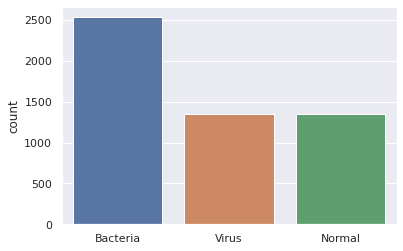

In [ ]:
plotting(train)

Count:  242 148 234


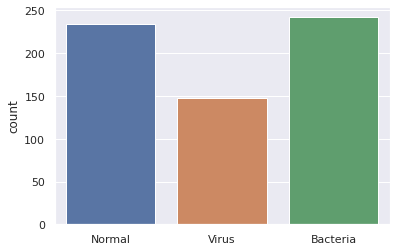

In [ ]:
plotting(test)

Count:  8 1 8


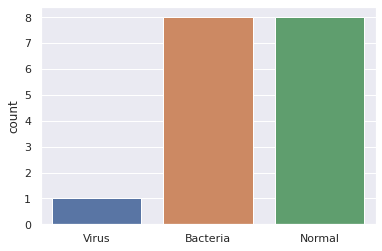

In [ ]:
plotting(val)

## Separation

In [ ]:
x_train = []
y_train = []

x_val = []
y_val = []

x_test = []
y_test = []

for feature, label in train:
    x_train.append(feature)
    y_train.append(label)

for feature, label in test:
    x_test.append(feature)
    y_test.append(label)
    
for feature, label in val:
    x_val.append(feature)
    y_val.append(label)

## Visualisation

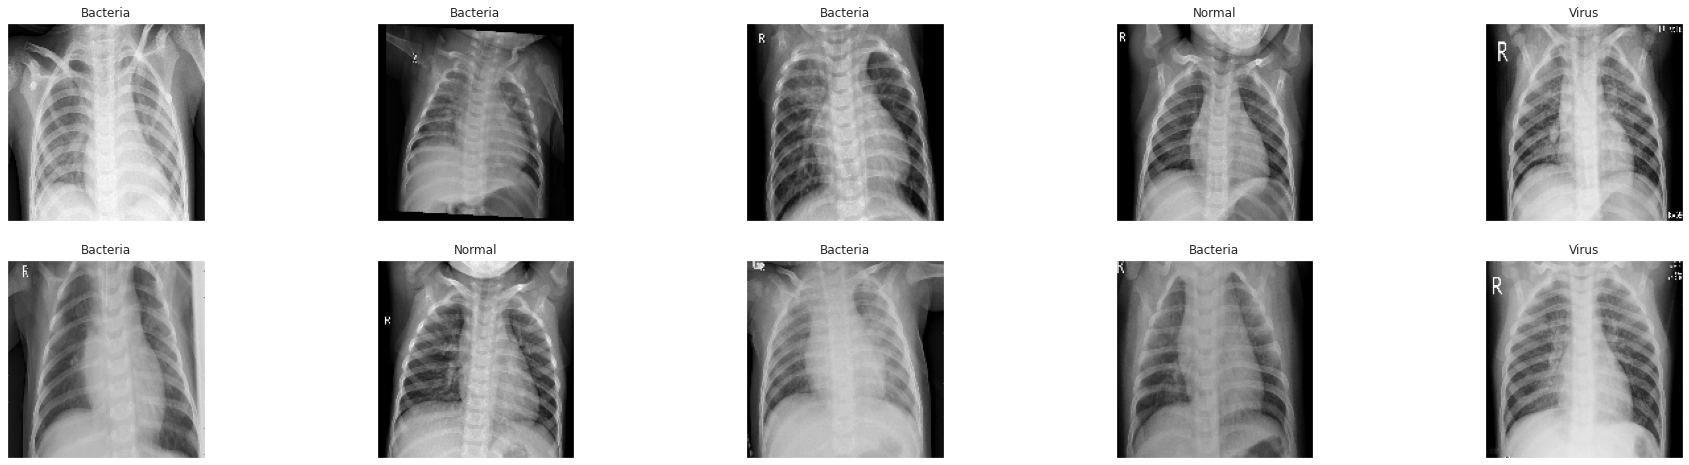

In [ ]:
fig, axes = plt.subplots(ncols=5, nrows=2, figsize=(32, 8))

indices = np.random.choice(len(x_train), 10)
counter = 0

for i in range(2):
    for j in range(5):
      if y_train[indices[counter]] == 0:
        axes[i,j].set_title('Normal')
      elif y_train[indices[counter]] == 1:
        axes[i,j].set_title('Bacteria')
      elif y_train[indices[counter]] == 2:
        axes[i,j].set_title('Virus')
      axes[i,j].imshow(x_train[indices[counter]], cmap='gray')
      axes[i,j].get_xaxis().set_visible(False)
      axes[i,j].get_yaxis().set_visible(False)
      counter += 1
plt.show()

# Normalize the data

To range 0-1

In [ ]:
x_train = np.array(x_train) / 255
x_val = np.array(x_val) / 255
x_test = np.array(x_test) / 255

Resize data for deep learning 

In [ ]:
x_train = x_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)

x_val = x_val.reshape(-1, img_size, img_size, 1)
y_val = np.array(y_val)

x_test = x_test.reshape(-1, img_size, img_size, 1)
y_test = np.array(y_test)

In [ ]:
np.unique(y_train, return_counts = True)

(array([0, 1, 2]), array([1349, 2533, 1346]))

In [ ]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
y_val = to_categorical(y_val)

In [ ]:
x_train.shape, x_test.shape, x_val.shape, y_train.shape, y_test.shape, y_val.shape

((5228, 150, 150, 1),
 (624, 150, 150, 1),
 (17, 150, 150, 1),
 (5228, 3),
 (624, 3),
 (17, 3))

# Training the Model 

With data augmentation to prevent overfitting and handling the imbalance in dataset

In [ ]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = True,  # randomly flip images
        vertical_flip=False)  # randomly flip images

datagen.fit(x_train)

**Cross-entropy** is the default loss function to use for multi-class classification problems. In this case, it is intended for use with multi-class classification where the target values are in the set {0, 1, 3, …, n}, where each class is assigned a unique integer value. The function requires that the output layer is configured with an n nodes (one for each class), in this case **three nodes**, and a *‘softmax‘* activation in order to predict the probability for each class. In turn, this means that the target variable must be one hot encoded.

**Dense Layer** is simple layer of neurons in which each neuron receives input from all the neurons of previous layer, thus called as dense. Dense Layer is used to classify image based on output from convolutional layers. Working of single neuron. A layer contains multiple number of such neurons.

A **flatten layer** collapses the spatial dimensions of the input into the channel dimension.

Another typical characteristic of CNNs is a **Dropout layer**. The Dropout layer is a mask that nullifies the contribution of some neurons towards the next layer and leaves unmodified all others. We can apply a Dropout layer to the input vector, in which case it nullifies some of its features; but we can also apply it to a hidden layer, in which case it nullifies some hidden neurons.

Dropout layers are important in training CNNs because they prevent overfitting on the training data. If they aren’t present, the first batch of training samples influences the learning in a disproportionately high manner. This, in turn, would prevent the learning of features that appear only in later samples or batches

In [ ]:
model = Sequential()
model.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (150,150,1)))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2), strides = 2))
model.add(Conv2D(64, (3,3), strides = 1, activation="relu"))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2), strides = 2))
model.add(Flatten())
model.add(Dense(1024, activation="relu"))  
model.add(Dense(200,activation="relu"))
model.add(Dense(3,activation="softmax"))

model.compile(
optimizer="adam",
loss="sparse_categorical_crossentropy",
metrics=['accuracy']
)
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 150, 150, 32)      320       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 75, 75, 32)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 73, 73, 64)        18496     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 36, 36, 64)       0         
 g2D)                                                            
                                                                 
 flatten_3 (Flatten)         (None, 82944)             0         
                                                                 
 dense_8 (Dense)             (None, 1024)             

# SGD

Model summary

---


In [ ]:
model = Sequential()
model.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , kernel_initializer='he_uniform', input_shape = (150,150,1)))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu', kernel_initializer='he_uniform'))
model.add(Dropout(0.1))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu', kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu', kernel_initializer='he_uniform'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu', kernel_initializer='he_uniform'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Flatten())
model.add(Dense(units = 128 , activation = 'relu', kernel_initializer='he_uniform'))
model.add(Dropout(0.2))
model.add(Dense(units = 3 , activation = 'softmax'))
opt = SGD(lr=0.01, momentum=0.9)
model.compile(optimizer = opt , loss = 'categorical_crossentropy' , metrics = ['accuracy'])
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_25 (Conv2D)          (None, 150, 150, 32)      320       
                                                                 
 batch_normalization_25 (Bat  (None, 150, 150, 32)     128       
 chNormalization)                                                
                                                                 
 max_pooling2d_25 (MaxPoolin  (None, 75, 75, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_26 (Conv2D)          (None, 75, 75, 64)        18496     
                                                                 
 dropout_20 (Dropout)        (None, 75, 75, 64)        0         
                                                                 
 batch_normalization_26 (Bat  (None, 75, 75, 64)      

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [ ]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)

Cca 1h 40min

In [ ]:
history = model.fit(datagen.flow(x_train,y_train, batch_size = 32) ,
                    epochs = 12 , 
                    validation_data = datagen.flow(x_val, y_val) ,
                    callbacks = [learning_rate_reduction])

Epoch 1/12
164/164 [==============================] - 458s 3s/step - loss: 0.9332 - accuracy: 0.5943 - val_loss: 6.9377 - val_accuracy: 0.4706 - lr: 0.0100
Epoch 2/12
164/164 [==============================] - 453s 3s/step - loss: 0.8162 - accuracy: 0.6222 - val_loss: 3.0254 - val_accuracy: 0.4706 - lr: 0.0100
Epoch 3/12
164/164 [==============================] - ETA: 0s - loss: 0.7995 - accuracy: 0.6305
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0029999999329447745.
164/164 [==============================] - 450s 3s/step - loss: 0.7995 - accuracy: 0.6305 - val_loss: 3.5933 - val_accuracy: 0.4706 - lr: 0.0100
Epoch 4/12
164/164 [==============================] - 448s 3s/step - loss: 0.7067 - accuracy: 0.6779 - val_loss: 2.4691 - val_accuracy: 0.4706 - lr: 0.0030
Epoch 5/12
164/164 [==============================] - 447s 3s/step - loss: 0.6438 - accuracy: 0.7137 - val_loss: 2.1054 - val_accuracy: 0.5294 - lr: 0.0030
Epoch 6/12
164/164 [==============================] - 447s 

Loss of the model is -  0.5885

Accuracy of the model is -  83.97 %

In [ ]:
print("Loss of the model is - " , model.evaluate(x_test,y_test)[0])
print("Accuracy of the model is - " , model.evaluate(x_test,y_test)[1]*100 , "%")

20/20 [==============================] - 11s 551ms/step - loss: 0.5885 - accuracy: 0.8397
Loss of the model is -  0.5884720087051392
20/20 [==============================] - 10s 515ms/step - loss: 0.5885 - accuracy: 0.8397
Accuracy of the model is -  83.97436141967773 %


## Analysis after Model Training

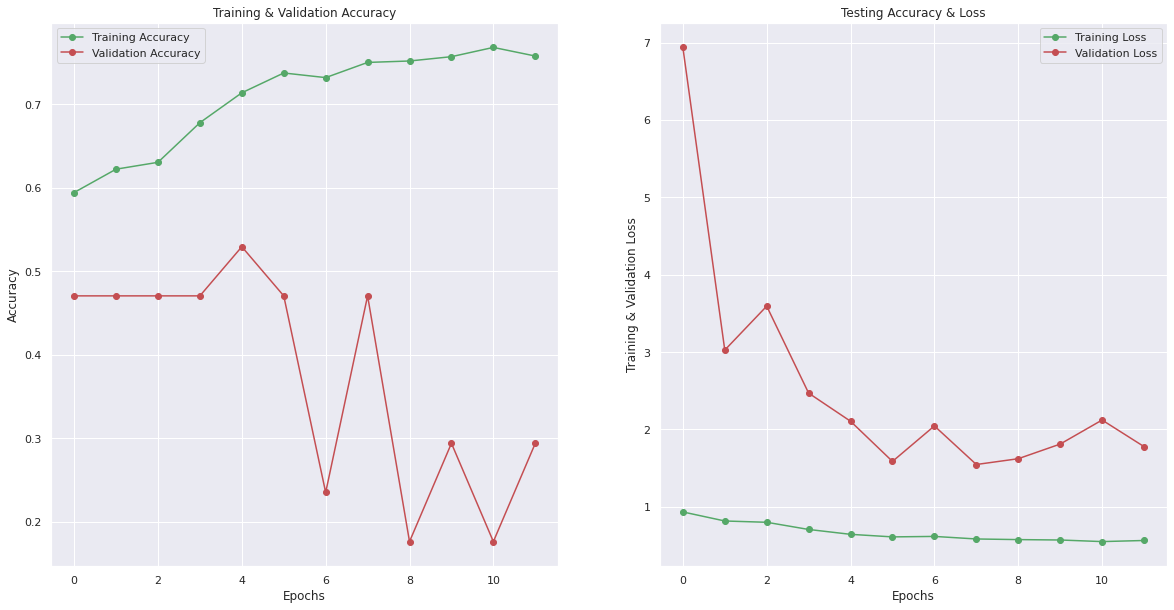

In [ ]:
epochs = [i for i in range(12)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Validation Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'r-o' , label = 'Validation Loss')
ax[1].set_title('Testing Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Training & Validation Loss")
plt.show()

# ADAM

In [ ]:
model = Sequential()
model.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , kernel_initializer='he_uniform', input_shape = (150,150,1)))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu', kernel_initializer='he_uniform'))
model.add(Dropout(0.1))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu', kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu', kernel_initializer='he_uniform'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu', kernel_initializer='he_uniform'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Flatten())
model.add(Dense(units = 128 , activation = 'relu', kernel_initializer='he_uniform'))
model.add(Dropout(0.2))
model.add(Dense(units = 3 , activation = 'softmax'))
model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 32)      320       
                                                                 
 batch_normalization (BatchN  (None, 150, 150, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 75, 75, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 75, 64)        18496     
                                                                 
 dropout (Dropout)           (None, 75, 75, 64)        0         
                                                                 
 batch_normalization_1 (Batc  (None, 75, 75, 64)       2

In [ ]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)

Cca 1h 35min

In [ ]:
history = model.fit(datagen.flow(x_train,y_train, batch_size = 32) ,
                    epochs = 12 , 
                    shuffle=True,
                    validation_data = datagen.flow(x_val, y_val) ,
                  callbacks = [learning_rate_reduction])

Epoch 1/12
164/164 [==============================] - 473s 3s/step - loss: 1.0103 - accuracy: 0.6027 - val_loss: 6.2098 - val_accuracy: 0.4706 - lr: 0.0010
Epoch 2/12
164/164 [==============================] - 454s 3s/step - loss: 0.7027 - accuracy: 0.6718 - val_loss: 5.9035 - val_accuracy: 0.4118 - lr: 0.0010
Epoch 3/12
164/164 [==============================] - 449s 3s/step - loss: 0.6831 - accuracy: 0.6788 - val_loss: 3.3527 - val_accuracy: 0.5294 - lr: 0.0010
Epoch 4/12
164/164 [==============================] - 461s 3s/step - loss: 0.6593 - accuracy: 0.6815 - val_loss: 1.0625 - val_accuracy: 0.6471 - lr: 0.0010
Epoch 5/12
164/164 [==============================] - 454s 3s/step - loss: 0.6140 - accuracy: 0.7228 - val_loss: 3.5638 - val_accuracy: 0.4118 - lr: 0.0010
Epoch 6/12
164/164 [==============================] - ETA: 0s - loss: 0.6061 - accuracy: 0.7349
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
164/164 [==============================] - 452s 

Loss of the model is -  0.5114

Accuracy of the model is -  85.1%

In [ ]:
print("Loss of the model is - " , model.evaluate(x_test,y_test)[0])
print("Accuracy of the model is - " , model.evaluate(x_test,y_test)[1]*100 , "%")

20/20 [==============================] - 13s 681ms/step - loss: 0.5114 - accuracy: 0.8510
Loss of the model is -  0.5113833546638489
20/20 [==============================] - 11s 561ms/step - loss: 0.5114 - accuracy: 0.8510
Accuracy of the model is -  85.09615659713745 %


## Analysis after Model Training

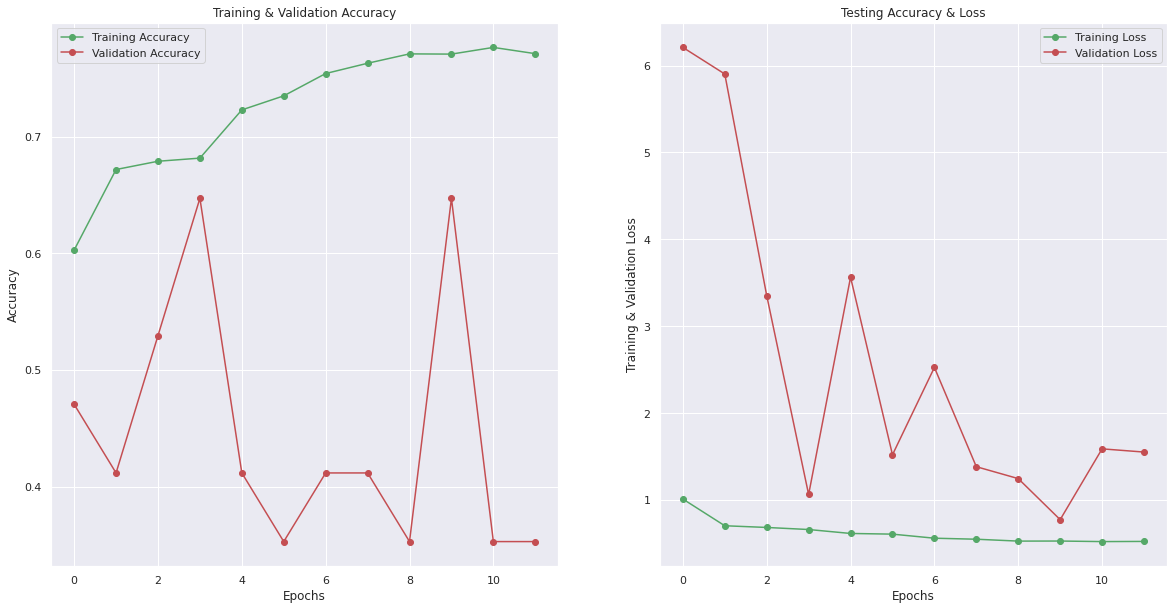

In [ ]:
epochs = [i for i in range(12)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Validation Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'r-o' , label = 'Validation Loss')
ax[1].set_title('Testing Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Training & Validation Loss")
plt.show()

In [ ]:
predictions = model.predict(x_test)
predictions[:15]

20/20 [==============================] - 10s 506ms/step


array([[2.39474639e-01, 3.66223425e-01, 3.94301921e-01],
       [1.03093602e-01, 4.92014319e-01, 4.04892117e-01],
       [9.30950880e-01, 3.00394669e-02, 3.90094966e-02],
       [3.78884673e-01, 2.82928795e-01, 3.38186622e-01],
       [1.56033397e-01, 4.48868483e-01, 3.95098031e-01],
       [9.86570477e-01, 4.29036748e-03, 9.13907215e-03],
       [2.26485566e-03, 7.21180260e-01, 2.76554793e-01],
       [9.77056980e-01, 8.92178714e-03, 1.40210968e-02],
       [9.02185798e-01, 4.20795269e-02, 5.57346568e-02],
       [6.59905636e-05, 7.69727945e-01, 2.30206132e-01],
       [1.47229970e-01, 4.01581377e-01, 4.51188534e-01],
       [7.97862053e-01, 9.35914665e-02, 1.08546436e-01],
       [6.08972739e-04, 8.37963521e-01, 1.61427483e-01],
       [9.53646958e-01, 1.87483057e-02, 2.76046172e-02],
       [2.25536805e-03, 8.02624762e-01, 1.95119932e-01]], dtype=float32)

## Report

In [ ]:
labels = np.array(['Normal (Class 0)','Bacteria (Class 1)','Virus (Class 2)'])
print(classification_report(np.argmax(y_test, axis=1), np.argmax(predictions, axis=1), target_names = labels))

                    precision    recall  f1-score   support

  Normal (Class 0)       0.93      0.84      0.89       234
Bacteria (Class 1)       0.81      0.95      0.88       242
   Virus (Class 2)       0.80      0.70      0.75       148

          accuracy                           0.85       624
         macro avg       0.85      0.83      0.84       624
      weighted avg       0.86      0.85      0.85       624



Confusion Matrix

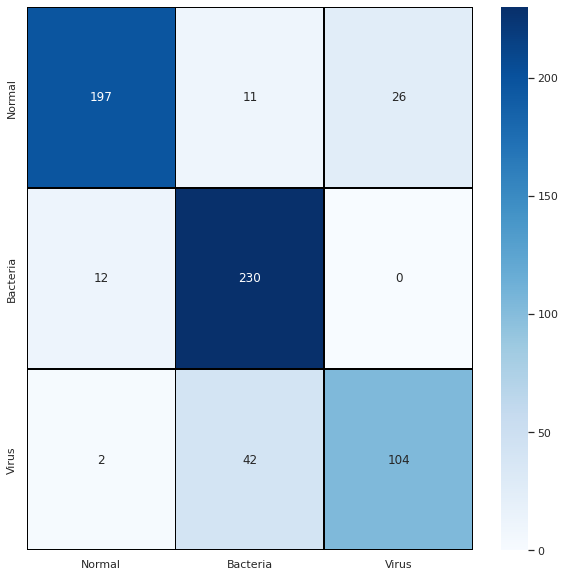

In [ ]:
cm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(predictions, axis=1))
cm = pd.DataFrame(cm , index = ['0','1','2'] , columns = ['0','1','2'])
plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='',xticklabels = ['Normal','Bacteria','Virus'],yticklabels = ['Normal','Bacteria','Virus'])

Some of the Incorrectly Predicted Classes

In [ ]:
correct = np.nonzero(predictions == y_test)[0]
incorrect = np.nonzero(predictions != y_test)[0]

In [ ]:
y_pred=[]
for sample in  predictions:
  y_pred.append([1 if i>=0.5 else 0 for i in sample ] )
y_pred = np.array(y_pred)
y_pred

array([[0, 0, 0],
       [0, 0, 0],
       [1, 0, 0],
       ...,
       [1, 0, 0],
       [1, 0, 0],
       [0, 1, 0]])

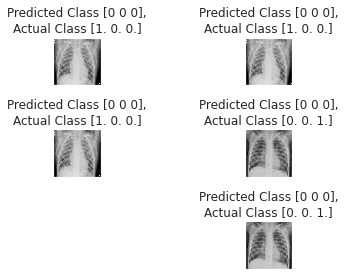

In [ ]:
i = 0
for c in incorrect[:6]:
    plt.subplot(3,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_test[c].reshape(150,150), cmap="gray", interpolation='none')
    plt.title("Predicted Class {},\nActual Class {}".format(y_pred[c], y_test[c]))
    plt.tight_layout()
    i += 1

# ADAGRAD

In [ ]:
model = Sequential()
model.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , kernel_initializer='he_uniform', input_shape = (150,150,1)))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu', kernel_initializer='he_uniform'))
model.add(Dropout(0.1))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu', kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu', kernel_initializer='he_uniform'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu', kernel_initializer='he_uniform'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Flatten())
model.add(Dense(units = 128 , activation = 'relu', kernel_initializer='he_uniform'))
model.add(Dropout(0.2))
model.add(Dense(units = 3 , activation = 'softmax'))
opt= keras.optimizers.Adagrad(learning_rate=1)
model.compile(optimizer = opt , loss = 'categorical_crossentropy' , metrics = ['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 150, 150, 32)      320       
                                                                 
 batch_normalization_15 (Bat  (None, 150, 150, 32)     128       
 chNormalization)                                                
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 75, 75, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_16 (Conv2D)          (None, 75, 75, 64)        18496     
                                                                 
 dropout_12 (Dropout)        (None, 75, 75, 64)        0         
                                                                 
 batch_normalization_16 (Bat  (None, 75, 75, 64)      

In [ ]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)

Cca 1h 40min

In [ ]:
history = model.fit(datagen.flow(x_train,y_train, batch_size = 32) ,
                    epochs = 12 , 
                    shuffle=True,
                    validation_data = datagen.flow(x_val, y_val) ,
                    callbacks = [learning_rate_reduction])

Epoch 1/12
164/164 [==============================] - 489s 3s/step - loss: 1.5228 - accuracy: 0.4858 - val_loss: 359.1703 - val_accuracy: 0.4706 - lr: 1.0000
Epoch 2/12
164/164 [==============================] - 498s 3s/step - loss: 1.0526 - accuracy: 0.4845 - val_loss: 1.1246 - val_accuracy: 0.4706 - lr: 1.0000
Epoch 3/12
164/164 [==============================] - ETA: 0s - loss: 1.0530 - accuracy: 0.4845
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.3.
164/164 [==============================] - 484s 3s/step - loss: 1.0530 - accuracy: 0.4845 - val_loss: 1.0913 - val_accuracy: 0.4706 - lr: 1.0000
Epoch 4/12
164/164 [==============================] - 466s 3s/step - loss: 1.0517 - accuracy: 0.4845 - val_loss: 1.0913 - val_accuracy: 0.4706 - lr: 0.0000e+00
Epoch 5/12
164/164 [==============================] - 457s 3s/step - loss: 1.0517 - accuracy: 0.4845 - val_loss: 1.0913 - val_accuracy: 0.4706 - lr: 0.0000e+00
Epoch 6/12
164/164 [==============================] - 452s 3s/step 

## Analysis after Model Training

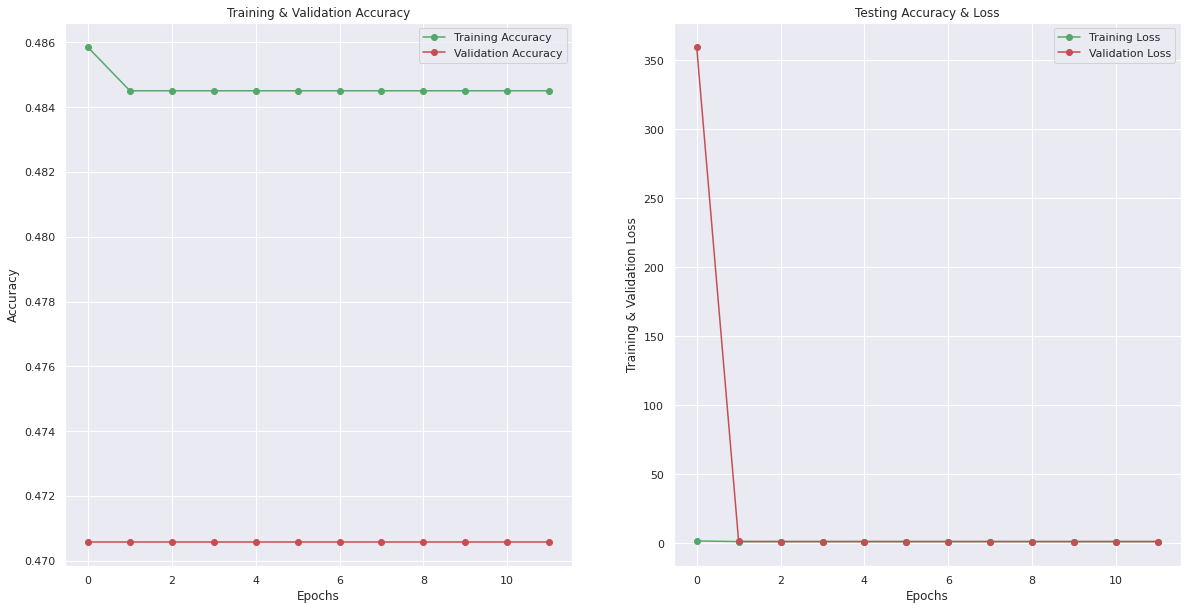

In [ ]:
epochs = [i for i in range(12)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Validation Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'r-o' , label = 'Validation Loss')
ax[1].set_title('Testing Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Training & Validation Loss")
plt.show()

In [ ]:
predictions = model.predict(x_test)
predictions[:15]

20/20 [==============================] - 12s 582ms/step


array([[0.24299538, 0.4740742 , 0.28293034],
       [0.24299538, 0.4740742 , 0.28293034],
       [0.24299538, 0.4740742 , 0.28293034],
       [0.24299538, 0.4740742 , 0.28293034],
       [0.24299538, 0.4740742 , 0.28293034],
       [0.24299538, 0.4740742 , 0.28293034],
       [0.24299538, 0.4740742 , 0.28293034],
       [0.24299538, 0.4740742 , 0.28293034],
       [0.24299538, 0.4740742 , 0.28293034],
       [0.24299538, 0.4740742 , 0.28293034],
       [0.24299538, 0.4740742 , 0.28293034],
       [0.24299538, 0.4740742 , 0.28293034],
       [0.24299538, 0.4740742 , 0.28293034],
       [0.24299538, 0.4740742 , 0.28293034],
       [0.24299538, 0.4740742 , 0.28293034]], dtype=float32)

## Report

In [ ]:
labels = np.array(['Normal (Class 0)','Bacteria (Class 1)','Virus (Class 2)'])
print(classification_report(np.argmax(y_test, axis=1), np.argmax(predictions, axis=1), target_names = labels))

                    precision    recall  f1-score   support

  Normal (Class 0)       0.00      0.00      0.00       234
Bacteria (Class 1)       0.39      1.00      0.56       242
   Virus (Class 2)       0.00      0.00      0.00       148

          accuracy                           0.39       624
         macro avg       0.13      0.33      0.19       624
      weighted avg       0.15      0.39      0.22       624



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Confusion Matrix

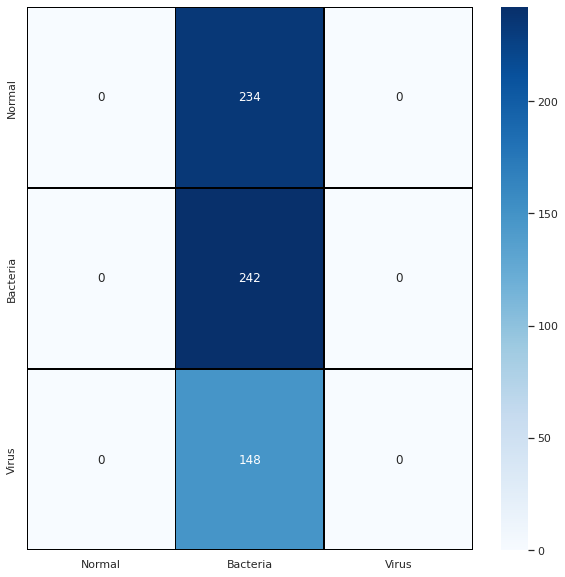

In [ ]:
cm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(predictions, axis=1))
cm = pd.DataFrame(cm , index = ['0','1','2'] , columns = ['0','1','2'])
plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='',xticklabels = ['Normal','Bacteria','Virus'],yticklabels = ['Normal','Bacteria','Virus'])

Some of the Incorrectly Predicted Classes

In [ ]:
correct = np.nonzero(predictions == y_test)[0]
incorrect = np.nonzero(predictions != y_test)[0]

In [ ]:
y_pred=[]
for sample in  predictions:
  y_pred.append([1 if i>=0.5 else 0 for i in sample ] )
y_pred = np.array(y_pred)
y_pred

array([[0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       ...,
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0]])

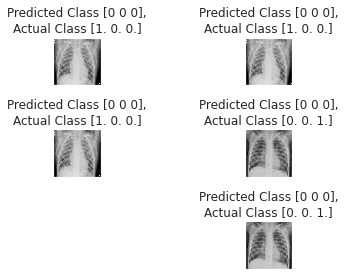

In [ ]:
i = 0
for c in incorrect[:6]:
    plt.subplot(3,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_test[c].reshape(150,150), cmap="gray", interpolation='none')
    plt.title("Predicted Class {},\nActual Class {}".format(y_pred[c], y_test[c]))
    plt.tight_layout()
    i += 1

# RMSprop

In [ ]:
model = Sequential()
model.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , kernel_initializer='he_uniform', input_shape = (150,150,1)))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu', kernel_initializer='he_uniform'))
model.add(Dropout(0.1))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu', kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu', kernel_initializer='he_uniform'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu', kernel_initializer='he_uniform'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Flatten())
model.add(Dense(units = 128 , activation = 'relu', kernel_initializer='he_uniform'))
model.add(Dropout(0.2))
model.add(Dense(units = 3 , activation = 'softmax'))
opt= keras.optimizers.RMSprop(lr=0.001)
model.compile(optimizer = opt , loss = 'categorical_crossentropy' , metrics = ['accuracy'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 150, 150, 32)      320       
                                                                 
 batch_normalization_20 (Bat  (None, 150, 150, 32)     128       
 chNormalization)                                                
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 75, 75, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_21 (Conv2D)          (None, 75, 75, 64)        18496     
                                                                 
 dropout_16 (Dropout)        (None, 75, 75, 64)        0         
                                                                 
 batch_normalization_21 (Bat  (None, 75, 75, 64)      

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/rmsprop.py:135: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


 chNormalization)                                                
                                                                 
 max_pooling2d_24 (MaxPoolin  (None, 5, 5, 256)        0         
 g2D)                                                            
                                                                 
 flatten_4 (Flatten)         (None, 6400)              0         
                                                                 
 dense_8 (Dense)             (None, 128)               819328    
                                                                 
 dropout_19 (Dropout)        (None, 128)               0         
                                                                 
 dense_9 (Dense)             (None, 3)                 387       
                                                                 
Total params: 1,246,659
Trainable params: 1,245,571
Non-trainable params: 1,088
______________________________________________________________

In [ ]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)

In [ ]:
history = model.fit(datagen.flow(x_train,y_train, batch_size = 32) ,
                    epochs = 12 , 
                    validation_data = datagen.flow(x_val, y_val) ,
                    callbacks = [learning_rate_reduction])

Epoch 1/12
164/164 [==============================] - 523s 3s/step - loss: 1.1440 - accuracy: 0.6109 - val_loss: 7.3139 - val_accuracy: 0.4706 - lr: 0.0010
Epoch 2/12
164/164 [==============================] - 495s 3s/step - loss: 0.7085 - accuracy: 0.7007 - val_loss: 9.1031 - val_accuracy: 0.4706 - lr: 0.0010
Epoch 3/12
164/164 [==============================] - ETA: 0s - loss: 0.6709 - accuracy: 0.7152
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
164/164 [==============================] - 473s 3s/step - loss: 0.6709 - accuracy: 0.7152 - val_loss: 6.0707 - val_accuracy: 0.3529 - lr: 0.0010
Epoch 4/12
164/164 [==============================] - 464s 3s/step - loss: 0.5758 - accuracy: 0.7596 - val_loss: 1.6748 - val_accuracy: 0.6471 - lr: 3.0000e-04
Epoch 5/12
164/164 [==============================] - 465s 3s/step - loss: 0.5564 - accuracy: 0.7599 - val_loss: 0.9877 - val_accuracy: 0.4706 - lr: 3.0000e-04
Epoch 6/12
164/164 [==============================]

## Analysis after Model Training

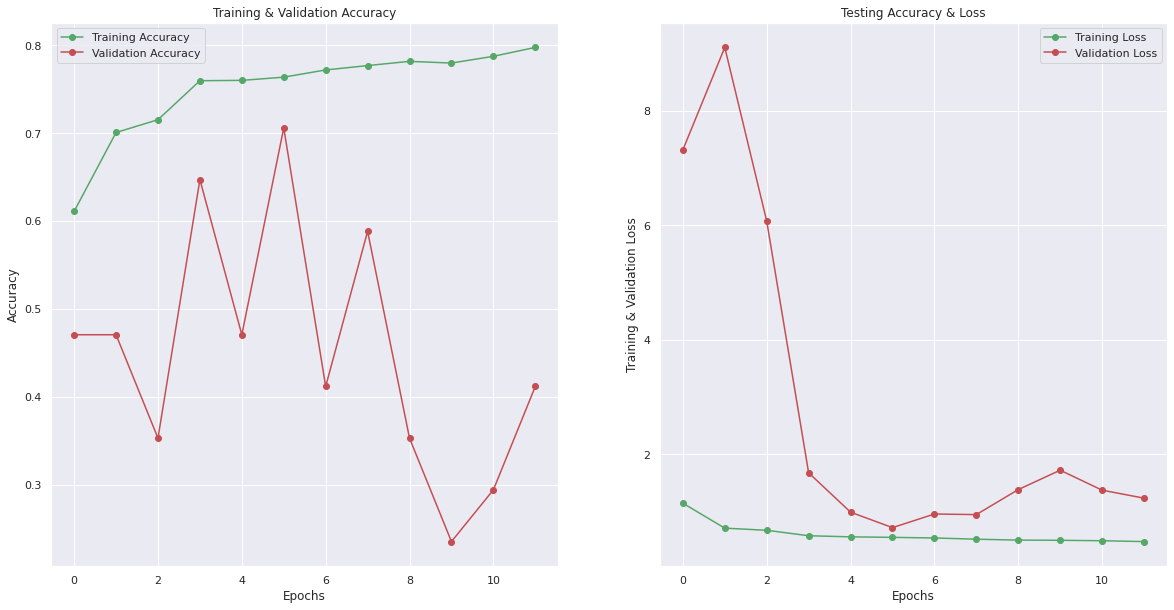

In [ ]:
epochs = [i for i in range(12)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Validation Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'r-o' , label = 'Validation Loss')
ax[1].set_title('Testing Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Training & Validation Loss")
plt.show()

In [ ]:
predictions = model.predict(x_test)
predictions[:15]

20/20 [==============================] - 10s 479ms/step


array([[5.1565409e-01, 9.9985547e-02, 3.8436034e-01],
       [2.4772146e-01, 4.0281940e-01, 3.4945908e-01],
       [9.9193203e-01, 1.5561729e-03, 6.5118191e-03],
       [8.7745005e-01, 3.3826180e-02, 8.8723809e-02],
       [2.4670917e-01, 2.4261518e-01, 5.1067549e-01],
       [9.9668843e-01, 1.6887038e-03, 1.6227550e-03],
       [3.1749087e-03, 6.7595422e-01, 3.2087085e-01],
       [9.8779947e-01, 3.2741213e-03, 8.9262920e-03],
       [9.4679224e-01, 1.1507410e-02, 4.1700326e-02],
       [4.4650871e-05, 7.7558041e-01, 2.2437496e-01],
       [6.1093944e-01, 1.2400120e-01, 2.6505926e-01],
       [9.2071337e-01, 3.4799539e-02, 4.4487178e-02],
       [2.3402097e-03, 7.6754808e-01, 2.3011179e-01],
       [9.5401102e-01, 3.2228354e-02, 1.3760481e-02],
       [2.1602318e-01, 4.6595293e-01, 3.1802392e-01]], dtype=float32)

## Report

In [ ]:
labels = np.array(['Normal (Class 0)','Bacteria (Class 1)','Virus (Class 2)'])
print(classification_report(np.argmax(y_test, axis=1), np.argmax(predictions, axis=1), target_names = labels))

                    precision    recall  f1-score   support

  Normal (Class 0)       0.81      0.91      0.85       234
Bacteria (Class 1)       0.89      0.90      0.89       242
   Virus (Class 2)       0.84      0.66      0.74       148

          accuracy                           0.84       624
         macro avg       0.84      0.82      0.83       624
      weighted avg       0.85      0.84      0.84       624



Confusion Matrix

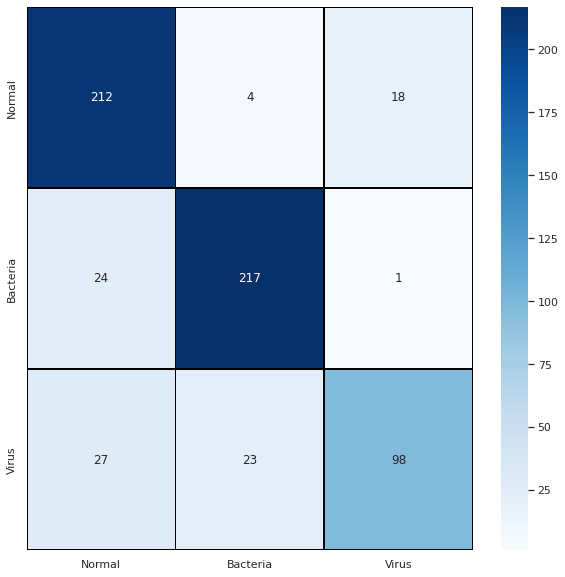

In [ ]:
cm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(predictions, axis=1))
cm = pd.DataFrame(cm , index = ['0','1','2'] , columns = ['0','1','2'])
plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='',xticklabels = ['Normal','Bacteria','Virus'],yticklabels = ['Normal','Bacteria','Virus'])

Some of the Incorrectly Predicted Classes

In [ ]:
y_pred=[]
for sample in  predictions:
  y_pred.append([1 if i>=0.5 else 0 for i in sample ] )
y_pred = np.array(y_pred)
y_pred

array([[1, 0, 0],
       [0, 0, 0],
       [1, 0, 0],
       ...,
       [1, 0, 0],
       [1, 0, 0],
       [0, 1, 0]])

In [ ]:
correct = np.nonzero(predictions == y_test)[0]
incorrect = np.nonzero(predictions != y_test)[0]

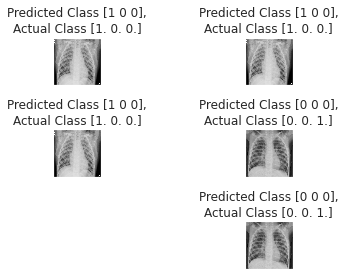

In [ ]:
i = 0
for c in incorrect[:6]:
    plt.subplot(3,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_test[c].reshape(150,150), cmap="gray", interpolation='none')
    plt.title("Predicted Class {},\nActual Class {}".format(y_pred[c], y_test[c]))
    plt.tight_layout()
    i += 1

# ADAM - 9 epoch

In [ ]:
model = Sequential()
model.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (150,150,1)))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.1))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Flatten())
model.add(Dense(units = 128 , activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(units = 3 , activation = 'softmax'))
opt = Adam(lr=0.001)
model.compile(optimizer = opt , loss = 'categorical_crossentropy' , metrics = ['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 150, 150, 32)      320       
                                                                 
 batch_normalization_10 (Bat  (None, 150, 150, 32)     128       
 chNormalization)                                                
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 75, 75, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 75, 75, 64)        18496     
                                                                 
 dropout_8 (Dropout)         (None, 75, 75, 64)        0         
                                                                 
 batch_normalization_11 (Bat  (None, 75, 75, 64)      

In [ ]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)

Cca 45min

In [ ]:
history = model.fit(datagen.flow(x_train,y_train, batch_size = 32) ,
                    epochs = 9 , 
                    shuffle=True,
                    validation_data = datagen.flow(x_val, y_val) ,
                  callbacks = [learning_rate_reduction])

Epoch 1/9
164/164 [==============================] - 268s 2s/step - loss: 0.9560 - accuracy: 0.6184 - val_loss: 11.0832 - val_accuracy: 0.4706 - lr: 0.0010
Epoch 2/9
164/164 [==============================] - 254s 2s/step - loss: 0.6944 - accuracy: 0.6871 - val_loss: 5.9075 - val_accuracy: 0.5294 - lr: 0.0010
Epoch 3/9
164/164 [==============================] - 248s 2s/step - loss: 0.6358 - accuracy: 0.7125 - val_loss: 7.4232 - val_accuracy: 0.1176 - lr: 0.0010
Epoch 4/9
164/164 [==============================] - 244s 1s/step - loss: 0.6178 - accuracy: 0.7251 - val_loss: 1.0273 - val_accuracy: 0.6471 - lr: 0.0010
Epoch 5/9
164/164 [==============================] - 275s 2s/step - loss: 0.6078 - accuracy: 0.7362 - val_loss: 8.6480 - val_accuracy: 0.4706 - lr: 0.0010
Epoch 6/9
164/164 [==============================] - ETA: 0s - loss: 0.6060 - accuracy: 0.7402
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
164/164 [==============================] - 251s 2s/st

Loss of the model is -  0.5114

Accuracy of the model is -  80.1%

In [ ]:
print("Loss of the model is - " , model.evaluate(x_test,y_test)[0])
print("Accuracy of the model is - " , model.evaluate(x_test,y_test)[1]*100 , "%")

20/20 [==============================] - 8s 378ms/step - loss: 0.8179 - accuracy: 0.7516
Loss of the model is -  0.8178900480270386
20/20 [==============================] - 7s 327ms/step - loss: 0.8179 - accuracy: 0.7516
Accuracy of the model is -  75.16025900840759 %


# Summary

In [ ]:
data = {'Opt':['SGD', 'Adam', 'Adam','Adagrad','RMSprop'],
        'Epoch':[12, 12, 9,  12, 12],
        'LR':[0.01, 0.001, 0.001, 1, 0.001],
        'Loss':[0.59, 0.51,0.8179, 1.05, 0.45],
        'Accuracy [%]':[75.77, 77.10, 76.72, 48.49, 79.74],
        'Accuracy test [%]':[83.97, 85.10, 75.16, 39, 84],}

df = pd.DataFrame(data)
print(df.set_index('Opt'))

         Epoch     LR    Loss  Accuracy [%]  Accuracy test [%]
Opt                                                           
SGD         12  0.010  0.5900         75.77              83.97
Adam        12  0.001  0.5100         77.10              85.10
Adam         9  0.001  0.8179         76.72              75.16
Adagrad     12  1.000  1.0500         48.49              39.00
RMSprop     12  0.001  0.4500         79.74              84.00
